In [1]:
import os
import pandas as pd
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp


In [2]:
import os
import pandas as pd

# Define the path to the 'combined_images' directory
base_path = 'combined_images'

# Define the mapping of classes to numerical labels
label_mapping = {
    'NonDemented': 0,
    'VeryMildDemented': 1,
    'MildDemented': 2,
    'ModerateDemented': 3
}

# Prepare lists to hold file paths and labels
file_paths = []
labels = []

# Iterate through each class directory and collect file paths and labels
for class_name, label in label_mapping.items():
    class_path = os.path.join(base_path, class_name)
    for file in os.listdir(class_path):
        # Only consider image files (assuming JPG, but adjust as necessary)
        if file.endswith('.jpg'):
            file_paths.append(os.path.join(class_path, file))
            labels.append(label)

# Create a DataFrame
df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Display the first few rows of the DataFrame
print(df.head())


                                           file_path  label
0  combined_images/NonDemented/cdc1752f-b9a5-4641...      0
1  combined_images/NonDemented/6083a08c-dc81-4e8d...      0
2         combined_images/NonDemented/nonDem1498.jpg      0
3         combined_images/NonDemented/nonDem2191.jpg      0
4  combined_images/NonDemented/6cee9615-8ab4-4069...      0


In [3]:
df.shape

(40384, 2)

In [4]:
label_counts = df['label'].value_counts()
print(label_counts)

label
0    12800
1    11200
2     9856
3     6528
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

# Split data into training plus validation and testing
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Split training plus validation data into separate training and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)  

# Optionally sample the training and validation set for hyperparameter tuning
#train_df = train_df.sample(frac=0.1, random_state=42)  # Adjust frac as needed for tuning
#val_df = val_df.sample(frac=0.5, random_state=42)  # Optionally adjust frac as needed for tuning

# Example: Cleaning NaN values from your dataframe (if applicable, especially for labels or any numerical features)
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

# Note: The test set should not be sampled or altered from its initial split
# test_df remains as is for final model evaluation to ensure accuracy of performance metrics

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Testing set size: {len(test_df)}") 

Training set size: 25845
Validation set size: 6462
Testing set size: 8077


In [6]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

class MRIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path).convert('L')  # Convert image to greyscale
        label = self.dataframe.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        #print(image.shape)
        label = torch.tensor(label, dtype=torch.long)  # Convert label to a LongTensor
        return image, label

# Define transformations/augmentations
transformations = transforms.Compose([
    transforms.Resize(128),  # Resize the image to ensure it's at least 128x128
    transforms.CenterCrop(128),  # Crop the center to get 128x128 pixels
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transformations = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create training and testing datasets
train_dataset = MRIDataset(train_df, transform=transformations)
val_dataset = MRIDataset(val_df, transform=val_test_transformations)
test_dataset = MRIDataset(test_df, transform=val_test_transformations)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Adjusted the size according to the corrected input image size
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Adjusted the flattening according to the corrected input image size
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
from tqdm.notebook import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn = SimpleCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

num_epochs = 50

# Start the training loop with timing
training_start_time = time.time()

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    epoch_start_time = time.time()
    
    model_cnn.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for images, labels in tqdm(train_loader, desc=f'Training Epoch {epoch+1}', leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_accuracy = 100 * correct_predictions / total_predictions
    epoch_end_time = time.time()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_end_time - epoch_start_time:.2f} sec')

training_end_time = time.time()
print(f'Total training time: {training_end_time - training_start_time:.2f} sec')


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 1/50, Loss: 1.0917, Accuracy: 49.15%, Time: 712.75 sec


Training Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 2/50, Loss: 0.9163, Accuracy: 57.79%, Time: 709.29 sec


Training Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 3/50, Loss: 0.8477, Accuracy: 61.20%, Time: 690.58 sec


Training Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 4/50, Loss: 0.7876, Accuracy: 64.55%, Time: 607.01 sec


Training Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 5/50, Loss: 0.7291, Accuracy: 67.19%, Time: 546.38 sec


Training Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 6/50, Loss: 0.6842, Accuracy: 69.61%, Time: 541.48 sec


Training Epoch 7:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 7/50, Loss: 0.6412, Accuracy: 71.98%, Time: 553.39 sec


Training Epoch 8:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 8/50, Loss: 0.6023, Accuracy: 73.62%, Time: 689.73 sec


Training Epoch 9:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 9/50, Loss: 0.5702, Accuracy: 75.35%, Time: 593.29 sec


Training Epoch 10:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 10/50, Loss: 0.5386, Accuracy: 77.04%, Time: 539.38 sec


Training Epoch 11:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 11/50, Loss: 0.5119, Accuracy: 78.48%, Time: 531.61 sec


Training Epoch 12:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 12/50, Loss: 0.4892, Accuracy: 79.17%, Time: 535.28 sec


Training Epoch 13:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 13/50, Loss: 0.4713, Accuracy: 80.23%, Time: 536.31 sec


Training Epoch 14:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 14/50, Loss: 0.4586, Accuracy: 80.48%, Time: 535.25 sec


Training Epoch 15:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 15/50, Loss: 0.4355, Accuracy: 81.68%, Time: 535.61 sec


Training Epoch 16:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 16/50, Loss: 0.4179, Accuracy: 82.70%, Time: 531.51 sec


Training Epoch 17:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 17/50, Loss: 0.4139, Accuracy: 82.52%, Time: 531.72 sec


Training Epoch 18:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 18/50, Loss: 0.3950, Accuracy: 83.51%, Time: 531.20 sec


Training Epoch 19:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 19/50, Loss: 0.3874, Accuracy: 84.09%, Time: 535.85 sec


Training Epoch 20:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 20/50, Loss: 0.3732, Accuracy: 84.52%, Time: 532.90 sec


Training Epoch 21:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 21/50, Loss: 0.3631, Accuracy: 85.03%, Time: 531.15 sec


Training Epoch 22:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 22/50, Loss: 0.3518, Accuracy: 85.59%, Time: 527.82 sec


Training Epoch 23:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 23/50, Loss: 0.3500, Accuracy: 85.46%, Time: 525.49 sec


Training Epoch 24:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 24/50, Loss: 0.3351, Accuracy: 86.31%, Time: 533.18 sec


Training Epoch 25:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 25/50, Loss: 0.3302, Accuracy: 86.34%, Time: 534.32 sec


Training Epoch 26:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 26/50, Loss: 0.3170, Accuracy: 87.02%, Time: 528.62 sec


Training Epoch 27:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 27/50, Loss: 0.3110, Accuracy: 87.17%, Time: 534.71 sec


Training Epoch 28:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 28/50, Loss: 0.3025, Accuracy: 87.47%, Time: 536.09 sec


Training Epoch 29:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 29/50, Loss: 0.2920, Accuracy: 88.25%, Time: 534.86 sec


Training Epoch 30:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 30/50, Loss: 0.2878, Accuracy: 88.25%, Time: 542.83 sec


Training Epoch 31:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 31/50, Loss: 0.2813, Accuracy: 88.65%, Time: 640.77 sec


Training Epoch 32:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 32/50, Loss: 0.2732, Accuracy: 88.83%, Time: 680.31 sec


Training Epoch 33:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 33/50, Loss: 0.2687, Accuracy: 89.17%, Time: 695.19 sec


Training Epoch 34:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 34/50, Loss: 0.2652, Accuracy: 89.34%, Time: 692.78 sec


Training Epoch 35:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 35/50, Loss: 0.2663, Accuracy: 89.10%, Time: 673.41 sec


Training Epoch 36:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 36/50, Loss: 0.2585, Accuracy: 89.42%, Time: 679.66 sec


Training Epoch 37:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 37/50, Loss: 0.2562, Accuracy: 89.62%, Time: 731.85 sec


Training Epoch 38:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 38/50, Loss: 0.2534, Accuracy: 89.80%, Time: 727.78 sec


Training Epoch 39:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 39/50, Loss: 0.2475, Accuracy: 90.13%, Time: 717.59 sec


Training Epoch 40:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 40/50, Loss: 0.2416, Accuracy: 90.17%, Time: 739.17 sec


Training Epoch 41:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 41/50, Loss: 0.2353, Accuracy: 90.48%, Time: 606.44 sec


Training Epoch 42:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 42/50, Loss: 0.2312, Accuracy: 90.60%, Time: 784.78 sec


Training Epoch 43:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 43/50, Loss: 0.2283, Accuracy: 90.70%, Time: 938.55 sec


Training Epoch 44:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 44/50, Loss: 0.2255, Accuracy: 90.83%, Time: 696.15 sec


Training Epoch 45:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 45/50, Loss: 0.2272, Accuracy: 90.88%, Time: 711.21 sec


Training Epoch 46:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 46/50, Loss: 0.2204, Accuracy: 91.10%, Time: 723.51 sec


Training Epoch 47:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 47/50, Loss: 0.2170, Accuracy: 91.37%, Time: 716.47 sec


Training Epoch 48:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 48/50, Loss: 0.2139, Accuracy: 91.43%, Time: 680.91 sec


Training Epoch 49:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 49/50, Loss: 0.2127, Accuracy: 91.37%, Time: 619.06 sec


Training Epoch 50:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 50/50, Loss: 0.2011, Accuracy: 91.94%, Time: 695.08 sec
Total training time: 31000.36 sec


In [10]:
# Validation phase with timing
validation_start_time = time.time()

# Initialize lists to store misclassified image data
misclassified_images = []
misclassified_true = []
misclassified_pred = []

model_cnn.eval()
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:  # Use val_loader or test_loader as needed
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()  # Accumulate the loss
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Identify misclassified images
        misclassified = predicted != labels
        for image, true_label, pred_label in zip(images[misclassified], labels[misclassified], predicted[misclassified]):
            misclassified_images.append(image.cpu())
            misclassified_true.append(true_label.cpu())
            misclassified_pred.append(pred_label.cpu())

validation_end_time = time.time()
print(f'Validation Accuracy: {100 * correct / total:.2f}%, Validation Loss: {val_loss / len(val_loader):.4f}, Time: {validation_end_time - validation_start_time:.2f} sec')


Validation Accuracy: 78.60%, Validation Loss: 0.7518, Time: 81.06 sec


In [11]:
def model_summary(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(f"Total Trainable Parameters: {params}")
    memory_usage = params * 4  # Assuming float32 (4 bytes per parameter)
    print(f"Estimated Model Memory Usage: {memory_usage / (1024**2):.2f} MB")

model_summary(model_cnn)

Total Trainable Parameters: 8408068
Estimated Model Memory Usage: 32.07 MB


                  precision    recall  f1-score   support

     NonDemented       0.81      0.82      0.81      2560
VeryMildDemented       0.74      0.71      0.72      2240
    MildDemented       0.77      0.77      0.77      1971
ModerateDemented       0.89      0.93      0.91      1306

        accuracy                           0.79      8077
       macro avg       0.80      0.81      0.80      8077
    weighted avg       0.79      0.79      0.79      8077



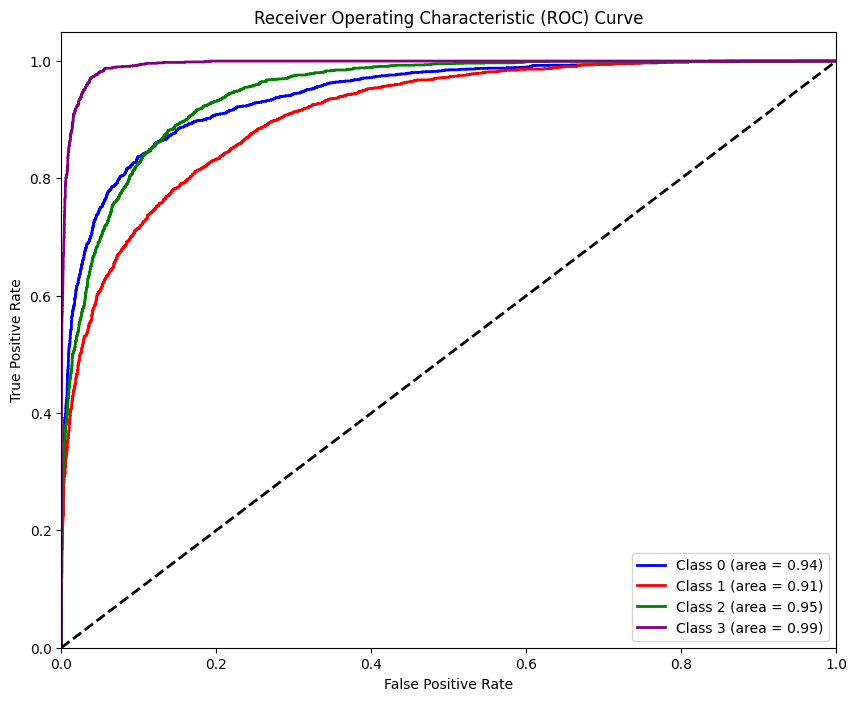

In [13]:
# Evaluation with Metrics and ROC Curve
def calculate_metrics_and_plot_roc(model, loader, num_classes):
    model.eval()
    y_true = []
    y_pred = []
    y_score = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(outputs.softmax(dim=1).cpu().numpy())
    
    print(classification_report(y_true, y_pred, target_names=list(label_mapping.keys())))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_true_one_hot = np.eye(num_classes)[y_true]
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], np.array(y_score)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    
    colors = cycle(['blue', 'red', 'green', 'purple'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate the model
calculate_metrics_and_plot_roc(model_cnn, test_loader, len(label_mapping))